In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt 

In [2]:
# Load the MATLAB file 
EEG_data = loadmat('/home/costanza/Robot-Control-by-EEG-with-ML/data/BCICIV_calib_ds1g.mat', struct_as_record = True)

# List all the keys in the loaded data
keys = EEG_data.keys()
# a,f :foot,right
# b,g
# Print the keys variables to identify the correct key for EEG data
print(keys)

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])


In [3]:
# Extract data
markers = EEG_data['mrk']
sfreq = EEG_data['nfo']['fs'][0][0][0][0]
EEGdata   = EEG_data['cnt'].T 
nchannels, nsamples = EEGdata.shape

time_unit = 1 / sfreq
print("Time Unit:", time_unit, "seconds")

chan_names = [s[0] for s in EEG_data['nfo']['clab'][0][0][0]]

event_onsets  = EEG_data['mrk'][0][0][0] # Time points when events occurred
event_codes   = EEG_data['mrk'][0][0][1] # It contains numerical or categorical labels associated with each event.
event_onset_time = event_onsets * time_unit # Seconds

# Creates an array of zeros and then assigns the event codes to the corresponding positions based on the event onsets.
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in EEG_data['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

# Electrode positions 
xpos = EEG_data['nfo']['xpos']
ypos = EEG_data['nfo']['ypos']

nclasses = len(cl_lab)
nevents = len(event_onsets)

# Print some information
print('Shape of EEG:', EEGdata.shape)
print('Sample rate:', sfreq)
print('Number of channels:', nchannels)
print('Channel names:', chan_names)
print('Number of events (MI movements):', event_onsets.shape[1])
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)


Time Unit: 0.01 seconds
Shape of EEG: (59, 190602)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events (MI movements): 200
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


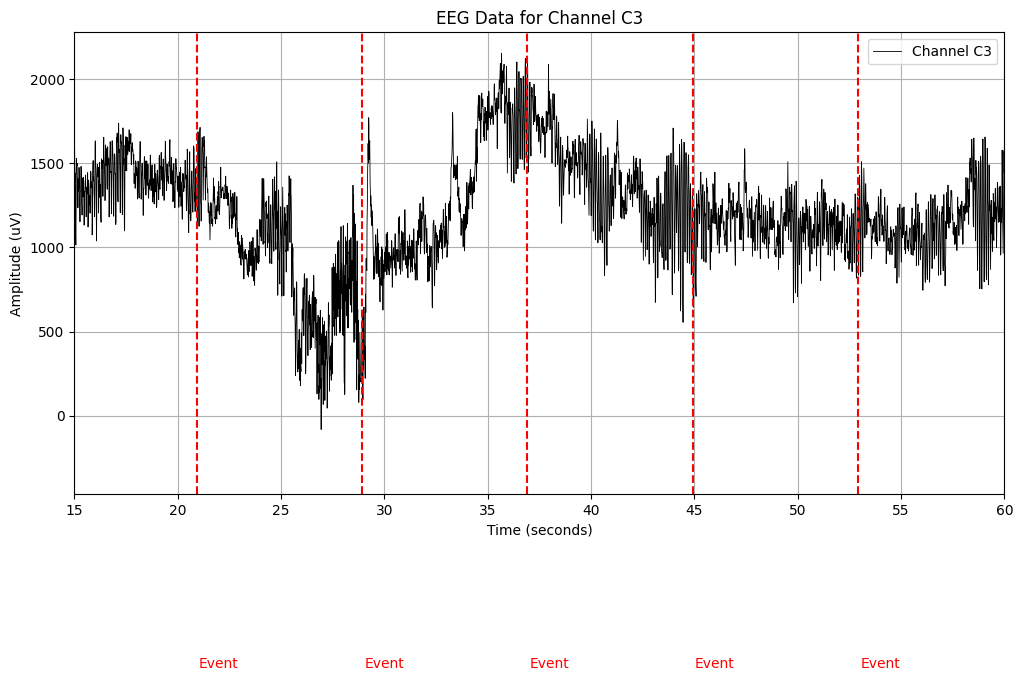

In [4]:
import matplotlib.pyplot as plt

# Select the first channel
channel_idx = 26 #C3
# channel_idx = 30 #C4
channel_data = EEGdata[channel_idx, :]

# Create a time axis
time_axis = np.arange(0, nsamples) * time_unit

# Specify the time range to zoom in (0 to 100 seconds)
start_time = 0
end_time = 60

# Find the corresponding indices for the specified time range
start_idx = int(start_time / time_unit)
end_idx = int(end_time / time_unit)

# Plot EEG data for the first channel within the specified time range
plt.figure(figsize=(12, 6))
plt.plot(time_axis[start_idx:end_idx], channel_data[start_idx:end_idx],color='black',linewidth=0.6, label=f'Channel {chan_names[channel_idx]}')
plt.title('EEG Data for Channel %s' % chan_names[channel_idx])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim((15,60))

# Plot vertical lines at the event onsets
valid_event_onsets = (start_time <= event_onset_time) & (event_onset_time <= end_time)

for onset_time in event_onset_time[valid_event_onsets]:
    plt.axvline(x=onset_time, color='red', linestyle='--')
    plt.text(onset_time + 0.1, -1500, 'Event', color='red')
    
    # Get the corresponding second value
    corresponding_second = int(onset_time)

plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Sequential Segmentation

# List of segments
trials_all = []

# The time window (in samples) to extract for each trial, here 0.5 -- 4.5 seconds
#win = np.arange(int(0.5*sfreq), int(4.5*sfreq)) # 400 samples
win = np.arange(int(0.5*sfreq), int(4.5*sfreq)) # 500 samples
nsamples_win = len(win)

# Loop through all events
for i in range(event_onsets.shape[1]):
    # Get the index of the event onset
    onset = event_onsets[:,i]

    trials_all.append(EEGdata[:, onset+win])

# Convert to NumPy array
trials_all = np.asarray(trials_all)
trials_all.shape

(200, 59, 400)

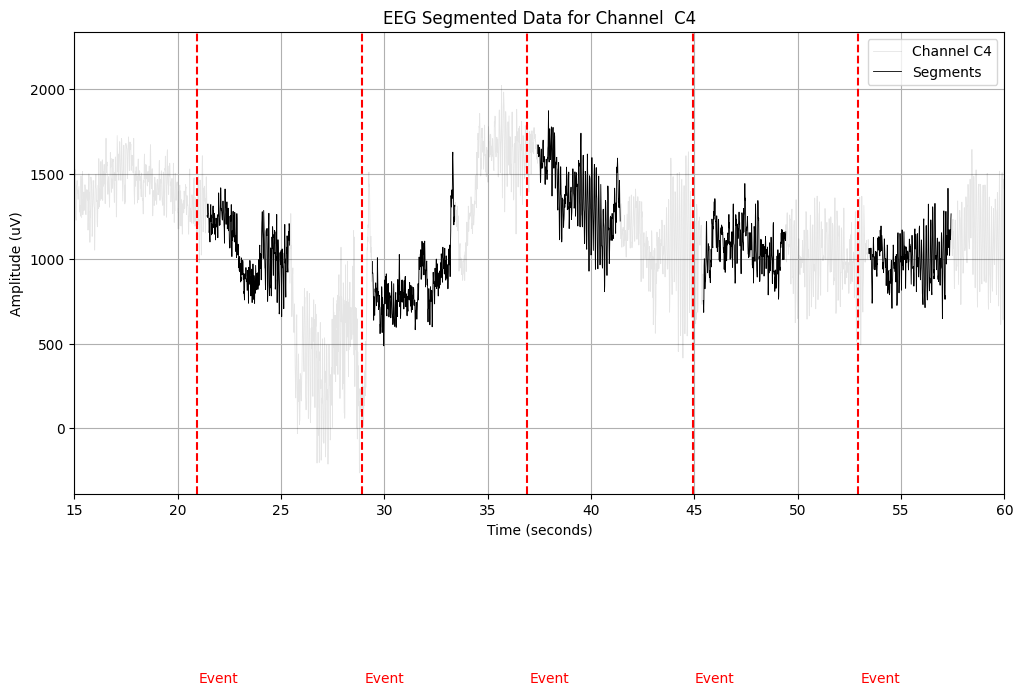

In [26]:
import matplotlib.pyplot as plt

# Select the first channel
channel_idx = 30
channel_data = EEGdata[channel_idx, :]

# Create a time axis
time_axis = np.arange(0, nsamples) * time_unit

# Specify the time range to zoom in (0 to 100 seconds)
start_time = 0
end_time = 60

# Find the corresponding indices for the specified time range
start_idx = int(start_time / time_unit)
end_idx = int(end_time / time_unit)

# Plot EEG data for the first channel within the specified time range
plt.figure(figsize=(12, 6))
plt.plot(time_axis[start_idx:end_idx], channel_data[start_idx:end_idx],color='black', alpha = 0.1,linewidth=0.6, label=f'Channel {chan_names[channel_idx]}')
plt.title('EEG Segmented Data for Channel  %s' % chan_names[channel_idx])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim((15,60))

# Plot vertical lines at the event onsets
valid_event_onsets = (start_time <= event_onset_time) & (event_onset_time <= end_time)

for onset_time in event_onset_time[valid_event_onsets]:
    plt.axvline(x=onset_time, color='red', linestyle='--')
    plt.text(onset_time + 0.1, -1500, 'Event', color='red')
    
    # Get the corresponding second value
    corresponding_second = int(onset_time)

x_trials = np.arange(0, nsamples_win)

for i, e in enumerate(event_onsets[0,:5]):
    if i == 0:
        plt.plot((win + e)*time_unit, trials_all[i, channel_idx, :], color='black', alpha=1, linewidth=0.6, label='Segments')
    else:
        plt.plot((win + e)*time_unit, trials_all[i, channel_idx, :], color='black', alpha=1, linewidth=0.6)

plt.legend( loc='upper right', )
plt.grid(True)
plt.show()


In [27]:
print(channel_data.shape)

(190602,)


In [28]:
# FFT

fft_all = []
fft_all = np.zeros_like(trials_all, dtype=complex)

for i in range(trials_all.shape[0]):
    for j in range(trials_all.shape[1]):
        fft_all[i,j,:] = np.abs(np.fft.fft(trials_all[i,j,:]))

fft_all.shape

(200, 59, 400)

/home/costanza/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


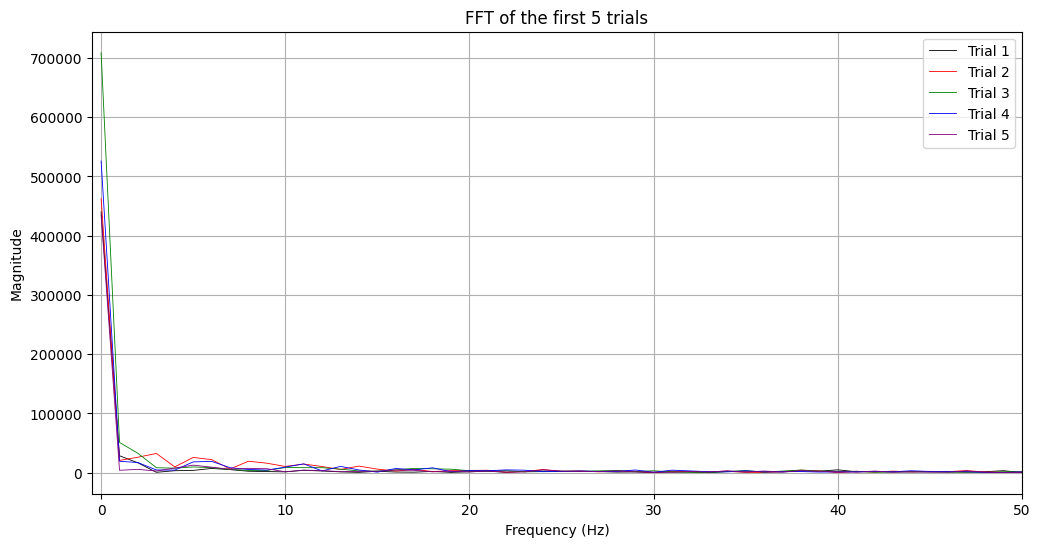

In [29]:
import matplotlib.pyplot as plt

# FFT of the whole signal
fft_eeg = np.abs(np.fft.fft(EEGdata))

# Plot the FFT of the first 5 trials and first channel with different color
channel_idx = 0
colors = ['black', 'red', 'green', 'blue', 'purple']
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(fft_all[i, channel_idx, :], color=colors[i], linewidth=0.6)

plt.legend(['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4', 'Trial 5'])
plt.title('FFT of the first 5 trials')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim((-0.5, 50))
plt.grid(True)


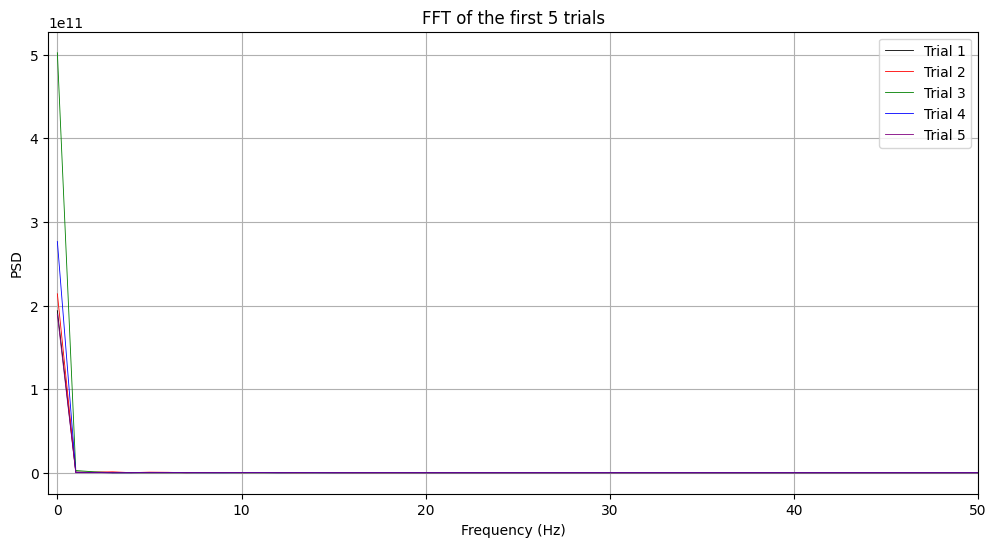

In [30]:
# PSD

psd_trials = np.abs(np.fft.fft(trials_all)) ** 2
# Plot the PSD of the first 5 trials and first channel with different color
channel_idx = 0
colors = ['black', 'red', 'green', 'blue', 'purple']
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(psd_trials[i, channel_idx, :], color=colors[i], linewidth=0.6)

plt.legend(['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4', 'Trial 5'])
plt.title('FFT of the first 5 trials')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.xlim((-0.5, 50))
plt.grid(True)

In [31]:
# Segmentation class dependent

# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 4.5 seconds
win = np.arange(int(0.5*sfreq), int(4.5*sfreq)) # 400 samples
nsamples_win = len(win)

# Loop over the classes (left, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]

    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples_win, len(cl_onsets)))

    # Extract each trial
    for i, onset in enumerate (cl_onsets):
        trials[cl][:,:,i] = EEGdata[:,win + onset]

print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 400, 100)
Shape of trials[cl2]: (59, 400, 100)


In [32]:
left  = np.rollaxis(trials[cl1], 2, 0)  
right = np.rollaxis(trials[cl2], 2, 0)
data = np.concatenate([left, right])

Y = np.concatenate([-np.ones(left.shape[0]), np.ones(right.shape[1])])

print(data.shape)
print(Y.shape)

(200, 59, 400)
(159,)


In [33]:
#fft
from scipy.fftpack import fft

fft_trials = {}

for cl in cl_lab:
    # Get the segmented data for the current class
    trials_cl = trials[cl]

    # Allocate memory for the FFT trials
    fft_trials[cl] = np.zeros_like(trials_cl, dtype=complex)

    # Compute FFT for each trial for selected channels
    for i in range(trials_cl.shape[2]):
        fft_trials[cl][:, :, i] = fft(trials_cl[:, :, i], axis=1)

# Calculate the magnitude of the FFT
for cl in fft_trials:
    fft_trials[cl] = np.abs(fft_trials[cl])

fft_trials[cl].shape

(59, 400, 100)

In [34]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Get the number of trials for each class
ntrials_cl1 = fft_trials[cl1].shape[2]
ntrials_cl2 = fft_trials[cl2].shape[2]
n_features = fft_trials[cl1].shape[0] * fft_trials[cl1].shape[1]

# Reshape the fft_trials data to fit the sklearn LDA
X_cl1 = fft_trials[cl1].reshape(ntrials_cl1, n_features)
X_cl2 = fft_trials[cl2].reshape(ntrials_cl2, n_features)

X = np.concatenate((X_cl1, X_cl2), axis = 0)

# Create the labels for the LDA (cl1 = -1, cl2 = 1)
y = np.concatenate((-np.ones(ntrials_cl1), np.ones(ntrials_cl2)))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)


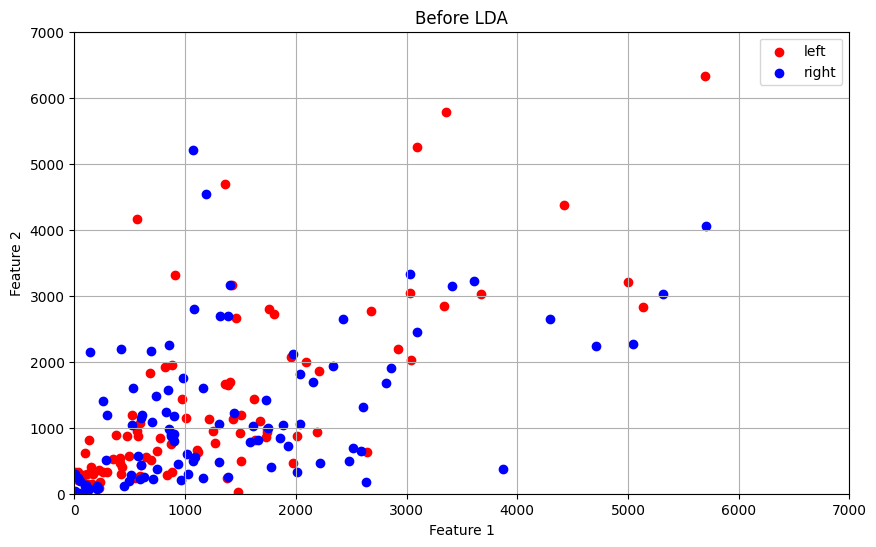

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(X_cl1[:, 0], X_cl1[:, 1], color='red', label=cl1)
plt.scatter(X_cl2[:, 0], X_cl2[:, 1], color='blue', label=cl2)
plt.title('Before LDA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim((-0.5, 7000))
plt.ylim((-0.5, 7000))
plt.legend()
plt.grid(True)
plt.show()

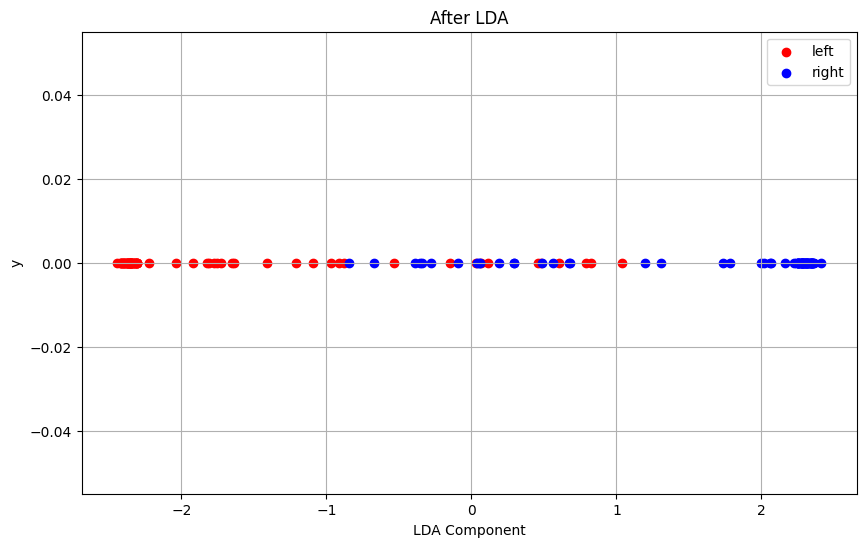

In [36]:
# scatter plot after LDA
plt.figure(figsize=(10, 6))
plt.scatter(X_train_lda[y_train==-1], np.zeros_like(X_train_lda[y_train==-1]), color='red', label=cl1)
plt.scatter(X_train_lda[y_train==1], np.zeros_like(X_train_lda[y_train==1]), color='blue', label=cl2)

plt.title('After LDA')
plt.xlabel('LDA Component')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
X_cl1.shape
X.shape

(200, 23600)

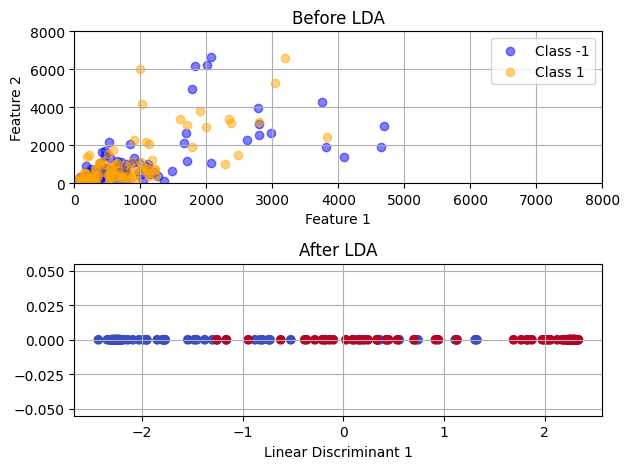

In [12]:
#LDA for dimensionality reduction

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split


n_trials_cl1 = fft_trials[cl1].shape[2]
n_trials_cl2 = fft_trials[cl2].shape[2]
n_features = fft_trials[cl1].shape[0] * fft_trials[cl1].shape[1]

X_cl1 = fft_trials[cl1].reshape((n_trials_cl1, n_features))
X_cl2 = fft_trials[cl2].reshape((n_trials_cl2, n_features))

X = np.concatenate((X_cl1, X_cl2),axis = 0)

y = np.concatenate((-np.ones(n_trials_cl1), np.ones(n_trials_cl2)))

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

lda = LinearDiscriminantAnalysis(n_components=1)

lda.fit(X, y)

X_lda = lda.transform(X)
# Define colors for each class
color_class1 = 'blue'
color_class2 = 'orange'

# Before LDA
plt.subplot(2, 1, 1)
plt.scatter(X_cl1[:, 0], X_cl1[:, 1], label='Class -1', alpha=0.5, color=color_class1)
plt.scatter(X_cl2[:, 0], X_cl2[:, 1], label='Class 1', alpha=0.5, color=color_class2)
plt.title('Before LDA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.legend()
plt.xlim((-0.5, 8000))
plt.ylim((-0.5, 8000))

# After LDA
plt.subplot(2, 1, 2)
plt.scatter(X_lda[:, 0], np.zeros_like(X_lda), c=y, cmap='coolwarm')
plt.title('After LDA')
plt.xlabel('Linear Discriminant 1')
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()




In [6]:
import mne

In [7]:
n_channels = 59

# Initialize an info structure
info = mne.create_info(
    ch_names = chan_names,
    ch_types = ['eeg'] * nchannels,
    sfreq = sfreq
)

print('Event created:', info)



Event created: <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


In [11]:
import numpy as np

# Assuming you have defined cl1 and cl2 earlier
events_id = {'left': -1, 'right': 1}  # Define event IDs

# Reshape event_onsets and event_codes to 2D arrays
event_onsets_2d = event_onsets.reshape(-1, 1)
event_codes_2d = event_codes.reshape(-1, 1)

# Create events array with three columns: onset, duration, event code
events = np.column_stack((event_onsets_2d, np.zeros_like(event_onsets_2d), event_codes_2d))

print("Events Array:")
print(events.shape)

Events Array:
(200, 3)


In [12]:
epochs = mne.EpochsArray(data, info, events=events, event_id=events_id, tmin=-0.5, verbose=True)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3478/76652734.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.average().plot(spatial_colors=True)


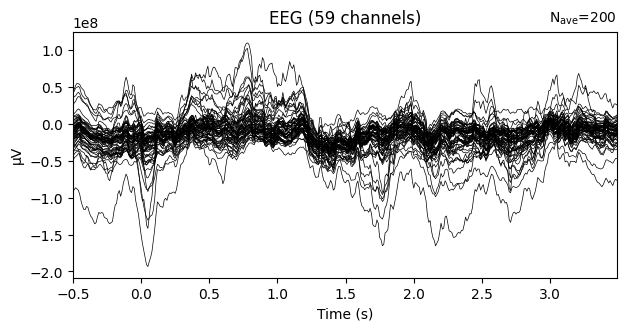

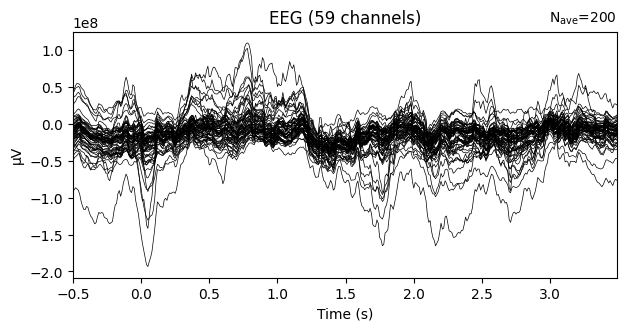

In [33]:
epochs.average().plot(spatial_colors=True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Need more than one channel to make topography for eeg. Disabling interactivity.


/tmp/ipykernel_3478/1875891995.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.average().pick_channels([channel_name]).plot(spatial_colors=True)


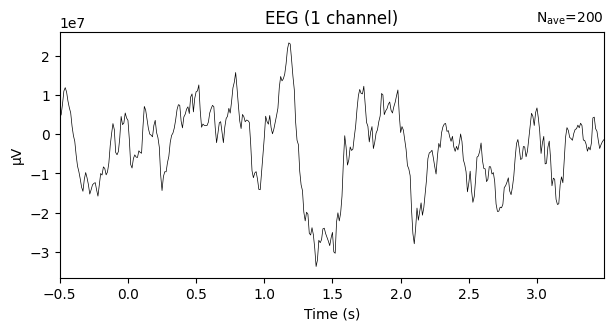

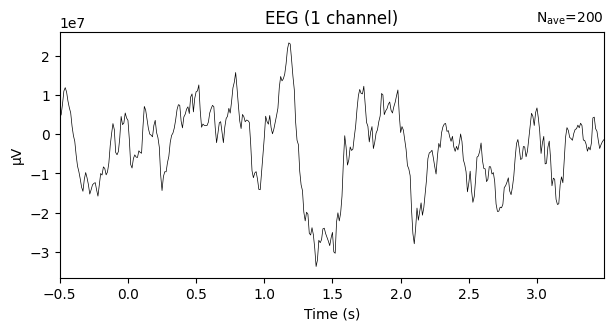

In [49]:
# Assuming 'channel_name' is the name of the channel you want to focus on
channel_name = 'Fz'  # Replace with the actual channel name

# Extract the data for the specific channel
epochs.average().pick_channels([channel_name]).plot(spatial_colors=True)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


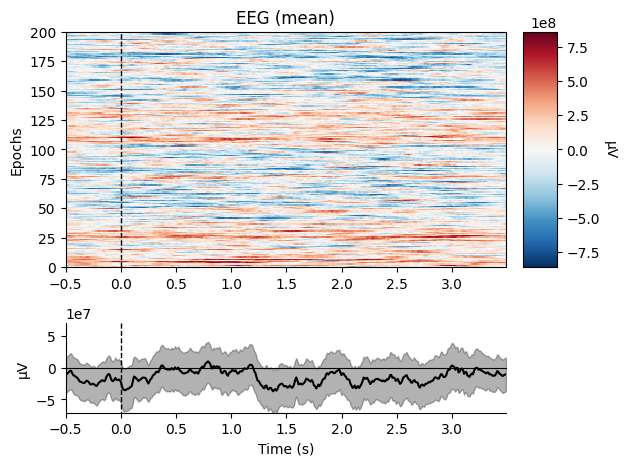

[<Figure size 640x480 with 3 Axes>]

In [41]:
epochs.plot_image(combine='mean')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/home/costanza/.local/lib/python3.8/site-packages/mne/viz/utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


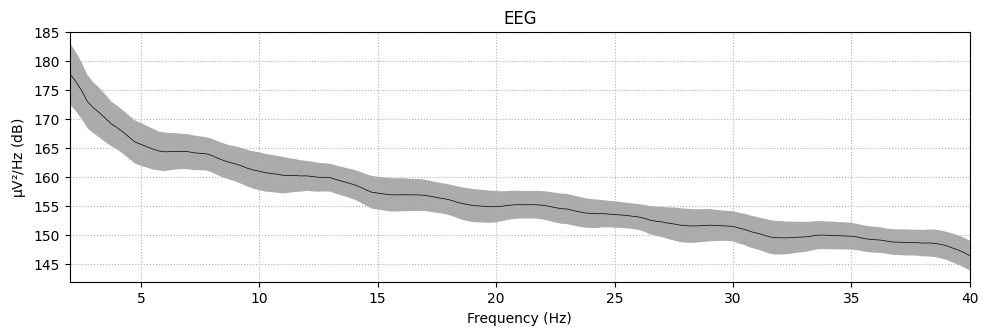

In [45]:
epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=True, dB=True)


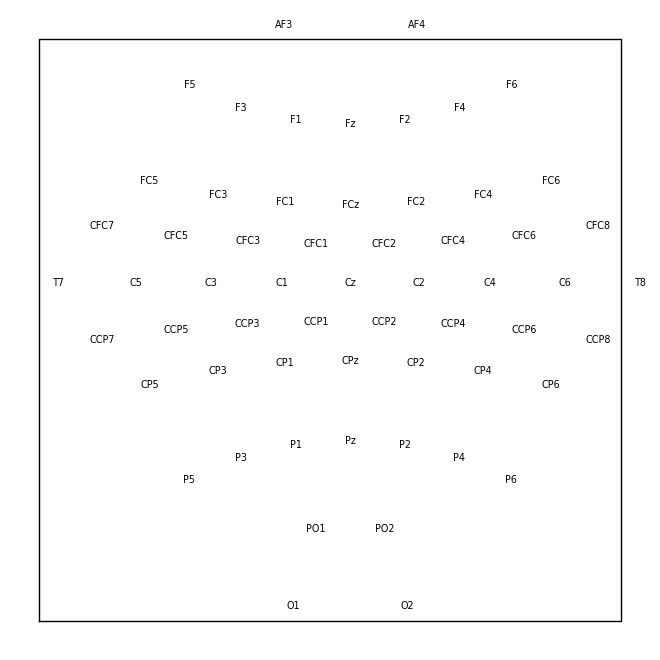

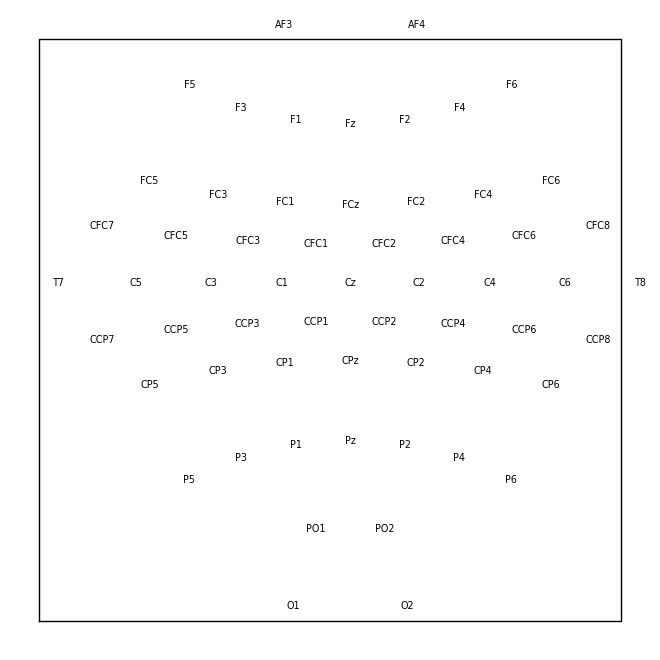

In [61]:
xpos = EEG_data['nfo']['xpos'][0][0]
ypos = EEG_data['nfo']['ypos'][0][0]
layout_pos = np.concatenate((xpos, ypos), axis = 1)

layout = mne.channels.generate_2d_layout(
    xy = layout_pos,
    ch_names = chan_names,
    name = 'EEG custom layout',
)

layout.plot()

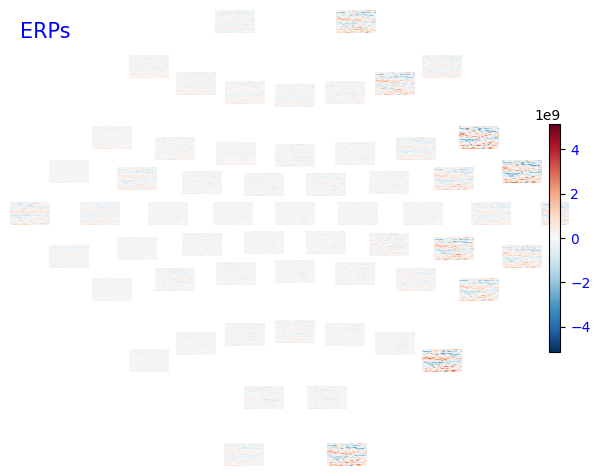

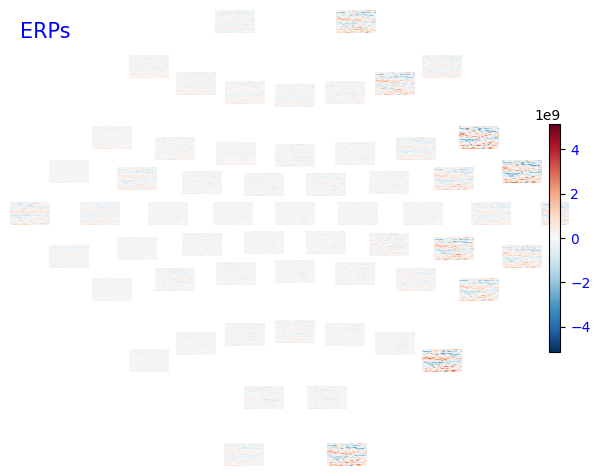

In [69]:
epochs.plot_topo_image(layout = layout, fig_facecolor = 'w', font_color = 'b', title = 'ERPs', colorbar = True)

In [17]:
from matplotlib import pyplot as plt

In [28]:
import matplotlib.pyplot as plt
import numpy as np

x1 = np.arange(3) # blank screen
x2 = np.arange(2,5) # MI
x3 = np.arange(4,7) # fixation cross (overlaps the MI)

n_bins = 1

plt.hist(x1, edgecolor='black', bins=n_bins, color = 'white', height = 1)
plt.hist(x2, edgecolor='black', bins=n_bins, color = 'white', height = 1)
plt.hist(x3, edgecolor='black', bins=n_bins, color = 'White', height = 1.5)

plt.xticks(np.arange(0, 9, 1))
plt.yticks(np.arange(0))

plt.xlabel('Time (s)')

# Add text inside the bins
for x_val in x1:
    plt.text(x_val, 0.5, 'Blank', ha='center', va='center')

for x_val in x2:
    plt.text(x_val, 0.5, 'MI', ha='center', va='center')

for x_val in x3:
    plt.text(x_val, 0.75, 'Fixation Cross', ha='center', va='center')


plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 640x480 with 1 Axes>